<a href="https://colab.research.google.com/github/ZahraDehghani99/Natural-Language-Processing/blob/main/HW5/text_classification_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Work5 - Document Categorization using Transformers

Text Classification using [ParsBERT](https://github.com/hooshvare/parsbert) and Multiligual modles

In [1]:
!pip install -q python-bidi arabic-reshaper

In [2]:
!pip install -q transformers datasets

In [3]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

# for diplay persian texts in the right way
from bidi.algorithm import get_display
from arabic_reshaper import reshape

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
!nvidia-smi

Fri Aug  5 12:45:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Read data and Data preprocessing

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/NLP/HW4/persica_final_edit.csv')
# df.columns = ['text', 'label']
# df.to_csv('/content/drive/MyDrive/NLP/HW5/persica_hw5.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/HW5/persica_hw5.csv')

In [ ]:
df.head()

,text,label
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...,آموزشي


In [ ]:
print(f'df shape : {df.shape}')

df shape : (10988, 2)


In [ ]:
df.label.value_counts()

آموزشي        1000
اقتصادي       1000
بهداشتي       1000
مذهبي         1000
اجتماعي        999
فرهنگي         999
ورزشي          999
تاريخي         998
سياسي          998
فقه و حقوق     998
علمي           997
Name: label, dtype: int64

Let's see the data distribution in each class.

In [ ]:
classes = [get_display(reshape(label)) for label in df.label]
y_fa = pd.DataFrame(classes)
y_fa.columns = ['label']

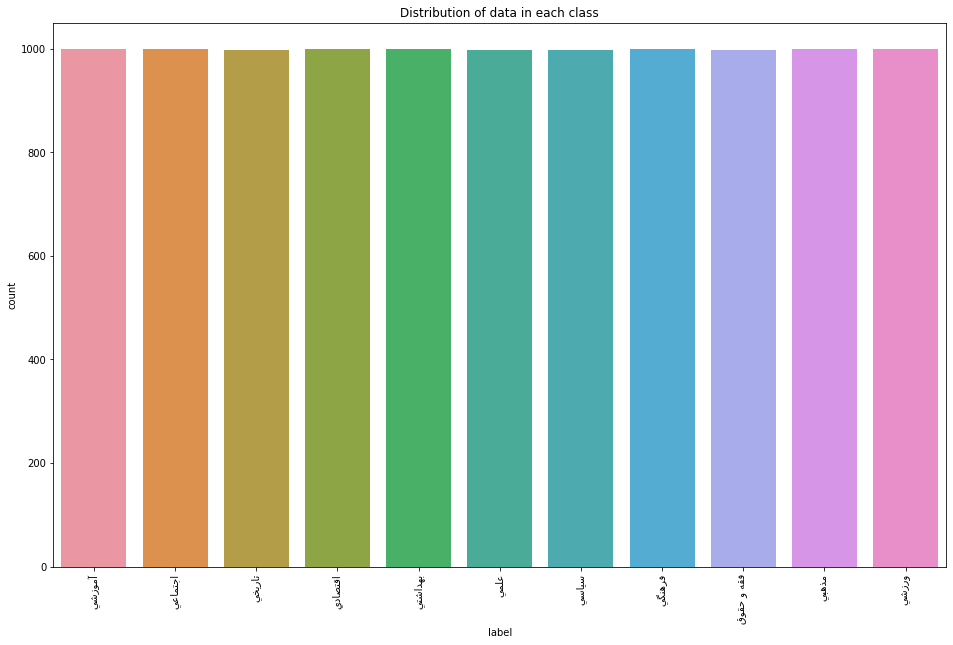

In [ ]:
fig = plt.figure(figsize=(16,10))
sns.countplot(x="label", data=y_fa)
plt.title("Distribution of data in each class")
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=15)
plt.show()

Let's see length of the news in each class.

In [ ]:
df["Word per New"] = df["text"].str.split().apply(len)

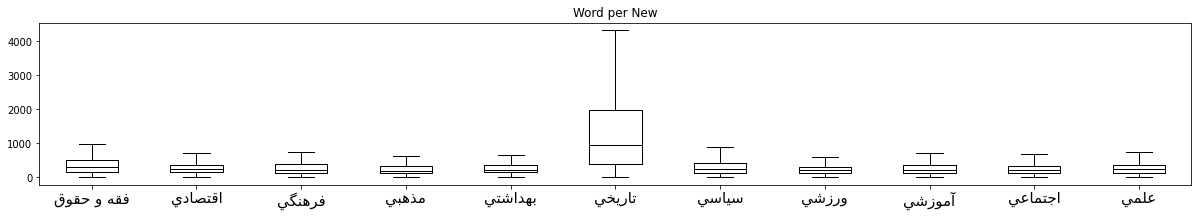

In [ ]:
df.boxplot("Word per New", by=y_fa["label"] , grid=False, showfliers=False,
           color="black")

plt.rcParams["figure.figsize"] = (20,3)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
df.head()

,text,label,Word per New
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي,365
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي,106
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي,114
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي,351
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...,آموزشي,215


In [ ]:
max(df["Word per New"])

6332

### Split X and y

In [ ]:
X = df.drop(columns=['Word per New', 'label'])
y = pd.DataFrame(df['label'])

print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')

X shape : (10988, 1)
y shape : (10988, 1)


In [ ]:
X.head()

,text
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...


### Train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (8790, 1)
X_test shape: (2198, 1)
y_train shape: (8790, 1)
y_test shape: (2198, 1)


### Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
y_train

array([8, 5, 3, ..., 4, 8, 1])

In [ ]:
inv =  le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
classes = []
for i in range(len(inv)):
  classes.append(inv[i])
  print(f'{inv[i]} => {i}')

آموزشي => 0
اجتماعي => 1
اقتصادي => 2
بهداشتي => 3
تاريخي => 4
سياسي => 5
علمي => 6
فرهنگي => 7
فقه و حقوق => 8
مذهبي => 9
ورزشي => 10


### Append y to x for train set and test set

In [ ]:
X_train['label'] = y_train.tolist()
X_test['label'] = y_test.tolist()

In [ ]:
# X_train.to_csv('/content/drive/MyDrive/HW5/data/train.csv', index=False)
# X_test.to_csv('/content/drive/MyDrive/HW5/data/test.csv', index=False)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/HW5/data/train.csv')
train.head()

,text,label
0,به گزارش خبرگزاري دانشجويان ايران (ايسنا) به ن...,5
1,رييس مركز مديريت بيماريهاي وزارت بهداشت از اجر...,3
2,به گزارش خبرنگار سياسي خبرگزاري دانشجويان ايرا...,5
3,به گزارش ايسنا، پويان شاهرخي مدير عامل خانه سي...,7
4,معاون سازمان سنجش آموزش كشور گفت: آزمون مرحله ...,0


In [ ]:
print(f'train shape : {train.shape}')

train shape : (8790, 2)


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/HW5/data/test.csv')
test.head()

,text,label
0,به گزارش خبرنگار سرويس ارتباطات خبرگزاري دانشج...,6
1,به گزارش ايسنا،در اين مراسم كه به رياست آقامحم...,10
2,به گزارش گروه دريافت ايسنا، حميد توكلي طاهباز،...,2
3,به گزارش خبرنگار خبرگزاري دانشجويان ايران (ايس...,7
4,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، تيم...,10


In [ ]:
print(f'test shape : {test.shape}')

test shape : (2198, 2)


## Load dataset using datasets

In [8]:
from datasets import load_dataset

PATH = "/content/drive/MyDrive/HW5/data (1)/"
dataset = load_dataset("csv", data_files={"train": PATH + "train.csv", "test": PATH + "test.csv"})

Using custom data configuration default-63293e9bc60040f4
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-63293e9bc60040f4/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8790
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2198
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 8790
})

In [ ]:
dataset['train'].features

{'label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

In [19]:
dataset['train'][0]

{'label': 5,
 'text': 'به گزارش خبرگزاري دانشجويان ايران (ايسنا) به نقل از خبرگزاري آسوشيتدپرس، تام ديلي، نماينده\u200cي جمهوري خواه تگزاس در مجلس نمايندگان پس از كناره\u200cگيري در نامه\u200cاي به همكاران جمهوريخواه خود نوشت: در طول دوران حضور من در كنگره هميشه در مسري اخلاق مدارانه حركت كرده\u200cام و قوانين سرزمين\u200cمان را مدنظر داشته\u200cام. وي كه در حال حاضر در تگزاس با دعوي\u200cاي عليه خود به خاطر تقلب انتخاباتي مواجه شده است، همواره تاكيد كرده كه پس از اثبات بي\u200cگناهي\u200cاش وظايف خود را مجددا از سر مي\u200cگيرد. رقابت بر سر جانشيني وي به عنوان رهبر اكثريت جمهوري خواه در مجلس نمايندگان شدت گرفته است. روي بلو نت، از ايالت ميسوري و جان بونر، از اوهايو مهم\u200cترين رقيبان براي تصدي اين پست مي\u200cباشند. از سوي ديگر دموكرات\u200cهاي كنگره در تلاش هستند كه در انتخابات ميان دوره\u200cيي مجلس كه در نوامبر 2006 برگزار خواهد شد، رياست مجلس را به دست آورند. نانسي پلوسي، از كاليفرنيا و رهبر دموكرات\u200cهاي مجلس در رابطه با رسوايي پيش آمده گفت: فرهنگ فساد و ارتشا در جناح جمهوري

## Define needed functions

### Defining the performance metrics

In [10]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids 
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### Defining Confusion matrix

In [11]:
classes = ["آموزشي", "اجتماعي", "اقتصادي", "بهداشتي", "تاريخي", "سياسي", "علمي", "فرهنگي", "فقه و حقوق", "مذهبي", "ورزشي"]
classes_fa_style = [get_display(reshape(i)) for i in classes]

In [12]:
def confusion_matrix(y_test, y_pred):
  labels = [i for i in range(len(list(set(y_test))))]
  df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = labels,
                columns = labels)
  plt.figure(figsize=(16,10))
  ax= plt.subplot()
  sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g', ax=ax)
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  class_names= classes
  # set persian names in correct way
  class_names = [get_display(reshape(label)) for label in class_names]
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()
  plt.show()

### Defining the label2int

In [13]:
def inverse(idx):
  inv = {0: "آموزشي",
         1: "اجتماعي",
         2: "اقتصادي",
         3: "بهداشتي",
         4: "تاريخي",
         5: "سياسي",
         6: "علمي",
         7: "فرهنگي",
         8: "فقه و حقوق",
         9: "مذهبي",
         10: "ورزشي"}
  return inv[idx]         

### Defining Forward parss loss

In [14]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                        reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
  "predicted_label": pred_label.cpu().numpy()}

## Text Classification using ParsBERT v1.0 Model

### Tokenizing the whole dataset

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='HooshvareLab/bert-base-parsbert-uncased', vocab_size=100000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.vocab_size

100000

In [ ]:
tokenizer.model_max_length

1000000000000000019884624838656

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

اینجا رو تغییر دادم. در سایز ورودی فکر کنم مشکل داره.

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [ ]:
print(tokenize(dataset["train"][0]))

{'input_ids': [2, 2031, 2248, 61826, 1216, 5360, 42906, 7764, 2616, 9, 7764, 39929, 10, 2031, 2836, 2036, 61826, 1216, 13697, 3806, 1160, 5458, 300, 9937, 47982, 1173, 1216, 300, 9010, 10308, 2062, 1216, 3277, 1216, 2683, 12673, 2028, 2543, 9010, 10308, 1160, 2276, 2297, 2036, 1, 2028, 22560, 1216, 2031, 1, 3277, 1216, 5596, 2081, 3695, 17, 2028, 2962, 3595, 2492, 2078, 2028, 1, 2063, 1216, 2749, 2028, 63781, 1216, 5976, 49909, 1, 1, 331, 3986, 10308, 5292, 30344, 2079, 2049, 7427, 17027, 15, 331, 1216, 1, 2028, 2290, 2863, 2028, 12673, 2037, 31533, 24277, 1216, 2395, 7880, 2081, 2031, 2855, 11040, 2829, 1216, 3440, 2110, 2045, 300, 4289, 1, 1, 1, 2297, 2036, 7151, 58465, 81593, 1177, 24277, 1176, 39810, 2081, 2049, 6944, 2036, 2140, 328, 1216, 1161, 25401, 1160, 15, 3396, 2043, 2140, 21782, 10308, 1216, 331, 1216, 2031, 2339, 4153, 1, 3277, 1216, 2683, 2028, 2543, 9010, 10308, 1160, 2276, 4306, 2563, 2045, 15, 38808, 5418, 3767, 300, 2036, 7764, 3064, 328, 52871, 2034, 1216, 331, 3059

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


### Fine-Tunning Transformers

You will see a warning that some parts of the model are randomly initialized.
This is normal since the classification head has not yet been trained. The n

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 11
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
model.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [ ]:
model.classifier

Linear(in_features=768, out_features=11, bias=True)

### Training the model

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"/content/drive/MyDrive/NLP/HW5/{model_ckpt}-finetuned-persika3"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  636652 KB |  636652 KB |  636652 KB |       0 B  |\n|       from large pool |  636128 KB |  636128 KB |  636128 KB |       0 B  |\n|       from small pool |     524 KB |     524 KB |     524 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  636652 KB |  636652 KB |  636652 KB |       0 B  |\n|       from large pool |  636128 KB |  636128 KB |

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.666700,0.414019,0.884895,0.886412
2,0.313000,0.457309,0.894449,0.893389


TrainOutput(global_step=2198, training_loss=0.4896761022230188, metrics={'train_runtime': 1999.4097, 'train_samples_per_second': 8.793, 'train_steps_per_second': 1.099, 'total_flos': 4625866127093760.0, 'train_loss': 0.4896761022230188, 'epoch': 2.0})

### Evaluation on the Test set

In [ ]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [ ]:
preds_output_test.metrics

{'test_accuracy': 0.8944494995450409,
 'test_f1': 0.893388662524686,
 'test_loss': 0.457309365272522,
 'test_runtime': 77.5658,
 'test_samples_per_second': 28.337,
 'test_steps_per_second': 3.545}

In [ ]:
y_test = np.array(dataset_encoded["test"]["label"])

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

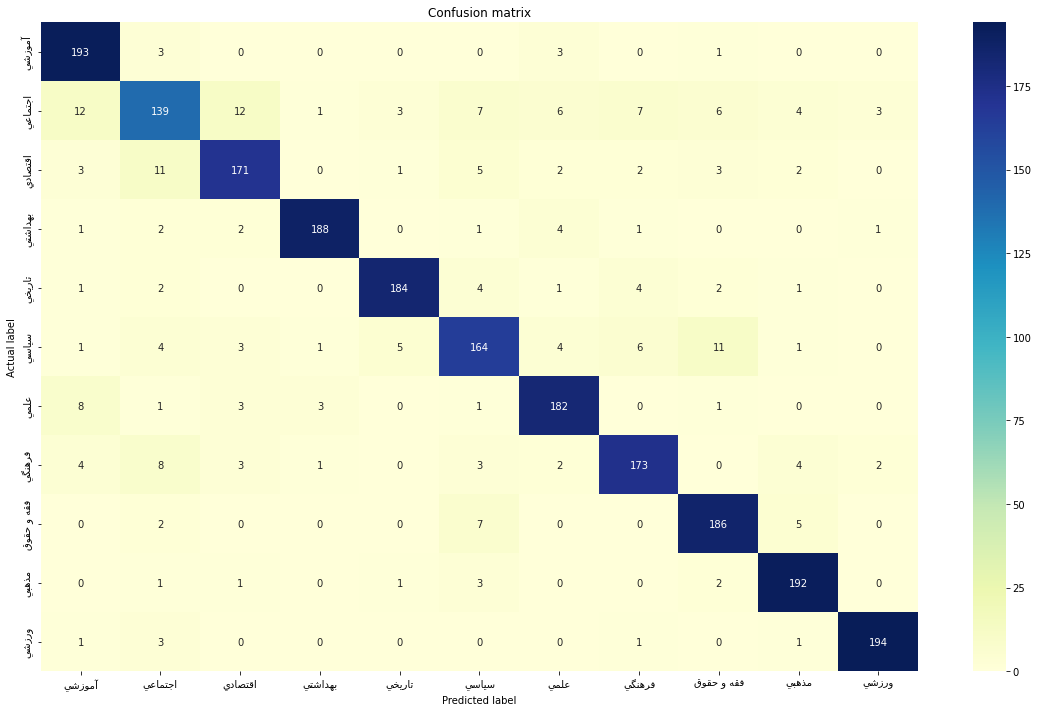

In [ ]:
confusion_matrix(y_test, y_preds_test)

In [ ]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.86      0.96      0.91       200\n           1       0.79      0.69      0.74       200\n           2       0.88      0.85      0.87       200\n           3       0.97      0.94      0.95       200\n           4       0.95      0.92      0.94       199\n           5       0.84      0.82      0.83       200\n           6       0.89      0.91      0.90       199\n           7       0.89      0.86      0.88       200\n           8       0.88      0.93      0.90       200\n           9       0.91      0.96      0.94       200\n          10       0.97      0.97      0.97       200\n\n    accuracy                           0.89      2198\n   macro avg       0.89      0.89      0.89      2198\nweighted avg       0.89      0.89      0.89      2198\n'

In [ ]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask",
"label"])
# Compute loss values
dataset_encoded["test"] = dataset_encoded["test"].map(
  forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/138 [00:00<?, ?ba/s]

In [ ]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,8.344843
2089,ميشل بالاك اخيرا در شهر ژنو سمت نمايندگي ويژه ...,اجتماعي,ورزشي,8.137333
318,در سال ‌٢٠٠٤ همه كشورها ملزم به اجراي مقاوله‌ن...,اقتصادي,فقه و حقوق,7.856896
1625,همچنين مراسم بزرگداشت آيت الله خاتمي بعد از ظه...,اجتماعي,تاريخي,7.683125
66,به گزارش گروه دريافت خبر “ايسنا“، يك مقام مسوو...,اقتصادي,علمي,7.659282
315,به گزارش خبرگزاري دانشجويان ايران (ايسنا)- منط...,اجتماعي,علمي,7.574035
2183,سرپرست فدراسيون وزنه‌برداري گفت:« استان خوزستا...,اجتماعي,ورزشي,7.506331
965,مشاور رييس دولت امارات گفت: سيره‌ي پيامبر (ص) ...,مذهبي,فقه و حقوق,7.461813
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,7.342851
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,7.301214


### Test the pipeline with a sample news

In [ ]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/NLP/HW5/HooshvareLab/bert-base-parsbert-uncased-finetuned-persika3/checkpoint-2000"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.0008129160851240158},
  {'label': 'LABEL_1', 'score': 0.001538837910629809},
  {'label': 'LABEL_2', 'score': 0.0009744007838889956},
  {'label': 'LABEL_3', 'score': 0.0006315947393886745},
  {'label': 'LABEL_4', 'score': 0.0006831648643128574},
  {'label': 'LABEL_5', 'score': 0.0013718188274651766},
  {'label': 'LABEL_6', 'score': 0.0018737983191385865},
  {'label': 'LABEL_7', 'score': 0.0016036168672144413},
  {'label': 'LABEL_8', 'score': 0.0004884147783741355},
  {'label': 'LABEL_9', 'score': 0.0010856053559109569},
  {'label': 'LABEL_10', 'score': 0.9889358878135681}]]

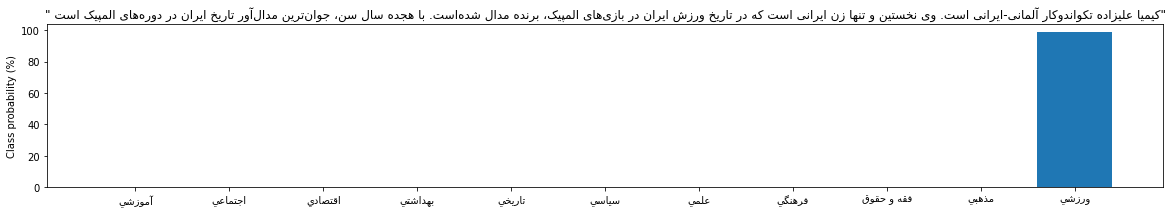

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد اما مدل آن را به عنوان خبر آموزشی تشخیص داده است.

In [ ]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.6814011335372925},
  {'label': 'LABEL_1', 'score': 0.1072152853012085},
  {'label': 'LABEL_2', 'score': 0.00429080193862319},
  {'label': 'LABEL_3', 'score': 0.00797261018306017},
  {'label': 'LABEL_4', 'score': 0.004660949110984802},
  {'label': 'LABEL_5', 'score': 0.04366200044751167},
  {'label': 'LABEL_6', 'score': 0.11752333492040634},
  {'label': 'LABEL_7', 'score': 0.015100887045264244},
  {'label': 'LABEL_8', 'score': 0.00796626415103674},
  {'label': 'LABEL_9', 'score': 0.0019263721769675612},
  {'label': 'LABEL_10', 'score': 0.008280381560325623}]]

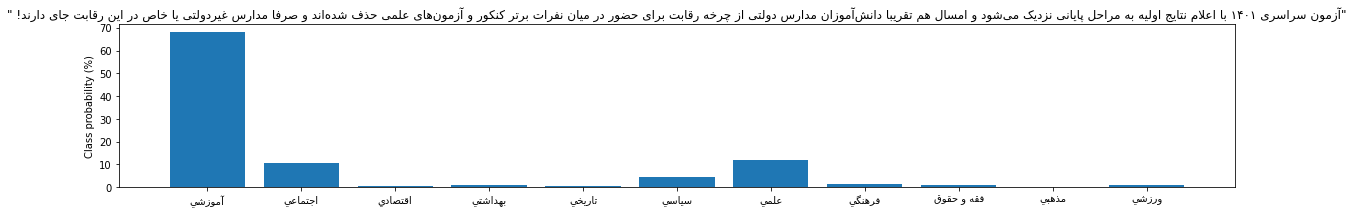

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## Text Classification using ParsBERT v2.0 Model

### Tokenizing the whole dataset

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "HooshvareLab/bert-fa-base-uncased-clf-persiannews"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='HooshvareLab/bert-fa-base-uncased-clf-persiannews', vocab_size=100000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.vocab_size

100000

In [ ]:
tokenizer.model_max_length

1000000000000000019884624838656

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

اینجا رو تغییر دادم. در سایز ورودی فکر کنم مشکل داره.

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [ ]:
print(tokenize(dataset["train"][0]))

{'input_ids': [2, 2789, 3361, 3350, 11535, 2038, 8350, 26168, 8568, 3414, 1006, 8568, 9141, 2006, 1007, 2789, 4134, 2791, 3350, 11535, 2038, 23225, 4707, 2013, 6523, 1348, 8319, 32694, 2010, 2038, 1348, 22696, 2956, 2038, 5244, 2038, 3513, 13084, 2786, 3590, 22696, 3702, 2965, 2791, 1, 2786, 20025, 2038, 2789, 1, 5244, 2038, 5705, 2847, 4113, 1014, 2786, 3417, 3775, 3470, 2842, 2786, 1, 2820, 2038, 5448, 2786, 70073, 2038, 7811, 77895, 1, 1, 1379, 4777, 11612, 13180, 35101, 2843, 2803, 10401, 23734, 1012, 75094, 1, 2786, 3035, 3802, 2786, 13084, 2799, 95953, 19006, 2038, 3127, 7691, 2847, 2789, 3804, 13406, 3958, 2038, 4574, 2871, 2806, 1348, 5293, 1, 1, 1, 2965, 2791, 6803, 62846, 5006, 2810, 19006, 2014, 58428, 2847, 2803, 7199, 2791, 2892, 59767, 2012, 19682, 2013, 1012, 4541, 2801, 2892, 23716, 11612, 2038, 75094, 2789, 3014, 5375, 1, 5244, 2038, 3513, 2786, 3590, 22696, 3702, 4931, 3296, 2806, 1012, 41386, 8049, 8115, 1348, 2791, 8568, 3729, 59767, 8611, 2038, 1379, 3607, 94753, 1

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


### Fine-Tunning Transformers

You will see a warning that some parts of the model are randomly initialized.
This is normal since the classification head has not yet been trained. The n

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 11
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True).to(device))

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Training the model

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"/content/drive/MyDrive/NLP/HW5/{model_ckpt}-finetuned-persika"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  659948 KB |    7616 MB |   56214 GB |   56214 GB |\n|       from large pool |  659424 KB |    7613 MB |   56207 GB |   56206 GB |\n|       from small pool |     524 KB |       3 MB |       7 GB |       7 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  659948 KB |    7616 MB |   56214 GB |   56214 GB |\n|       from large pool |  659424 KB |    7613 MB |

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.660600,0.462859,0.872157,0.874821
2,0.317800,0.477702,0.888990,0.888073


TrainOutput(global_step=2198, training_loss=0.48884593478460764, metrics={'train_runtime': 2000.7451, 'train_samples_per_second': 8.787, 'train_steps_per_second': 1.099, 'total_flos': 4625866127093760.0, 'train_loss': 0.48884593478460764, 'epoch': 2.0})

### Evaluation on the Test set

In [ ]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [ ]:
preds_output_test.metrics

{'test_accuracy': 0.8889899909008189,
 'test_f1': 0.8880732026073239,
 'test_loss': 0.4777015745639801,
 'test_runtime': 77.5474,
 'test_samples_per_second': 28.344,
 'test_steps_per_second': 3.546}

In [ ]:
y_test = np.array(dataset_encoded["test"]["label"])

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

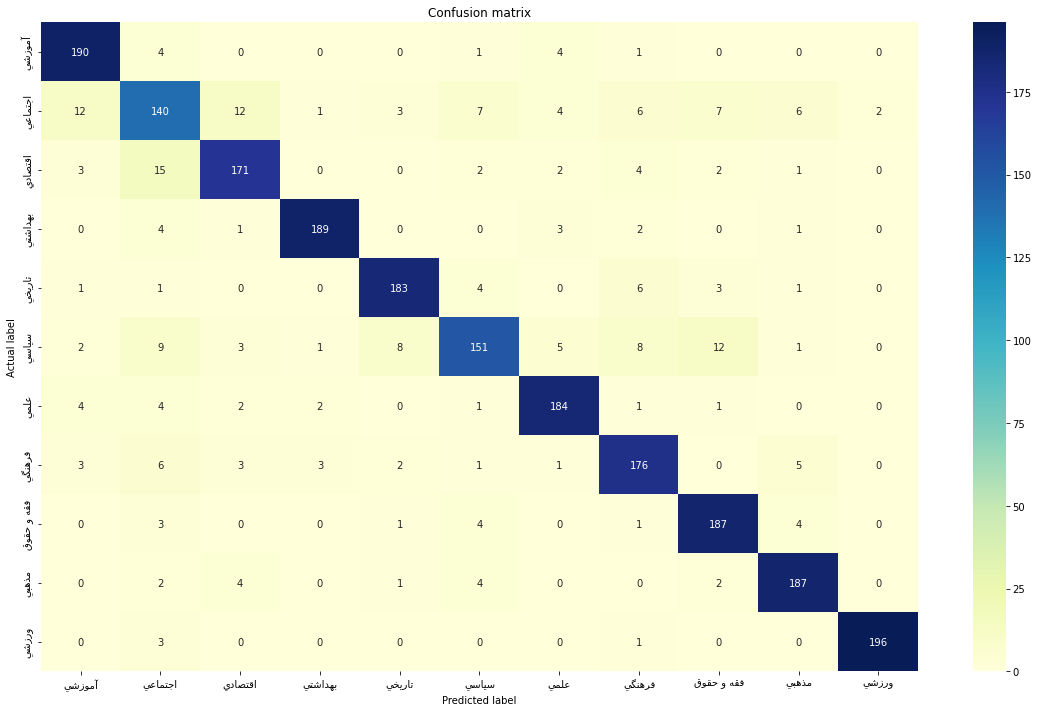

In [ ]:
confusion_matrix(y_test, y_preds_test)

In [ ]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.88      0.95      0.92       200\n           1       0.73      0.70      0.72       200\n           2       0.87      0.85      0.86       200\n           3       0.96      0.94      0.95       200\n           4       0.92      0.92      0.92       199\n           5       0.86      0.76      0.81       200\n           6       0.91      0.92      0.92       199\n           7       0.85      0.88      0.87       200\n           8       0.87      0.94      0.90       200\n           9       0.91      0.94      0.92       200\n          10       0.99      0.98      0.98       200\n\n    accuracy                           0.89      2198\n   macro avg       0.89      0.89      0.89      2198\nweighted avg       0.89      0.89      0.89      2198\n'

In [ ]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask",
"label"])
# Compute loss values
dataset_encoded["test"] = dataset_encoded["test"].map(
  forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/138 [00:00<?, ?ba/s]

In [ ]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,8.826341
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,8.178761
465,به گزارش اداره كل روابط عمومي و بين‌الملل شهرد...,سياسي,اجتماعي,8.159173
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,8.069651
2188,برنامه كارگاه آموزش عملي دانشكده علوم دانشگاه ...,سياسي,علمي,7.996334
965,مشاور رييس دولت امارات گفت: سيره‌ي پيامبر (ص) ...,مذهبي,فقه و حقوق,7.844840
3,به گزارش خبرنگار خبرگزاري دانشجويان ايران (ايس...,فرهنگي,بهداشتي,7.771376
714,به گزارش ايسنا، پژوهشگران از رشد سريع ماهواره‌...,اجتماعي,علمي,7.764572
66,به گزارش گروه دريافت خبر “ايسنا“، يك مقام مسوو...,اقتصادي,علمي,7.760775
1553,به گزارش ايسنا، به نقل ازروابط عمومي وزارت بهد...,اجتماعي,بهداشتي,7.712973


### Test the pipeline with a sample news

In [ ]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/NLP/HW5/HooshvareLab/bert-fa-base-uncased-clf-persiannews-finetuned-persika/checkpoint-2000"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

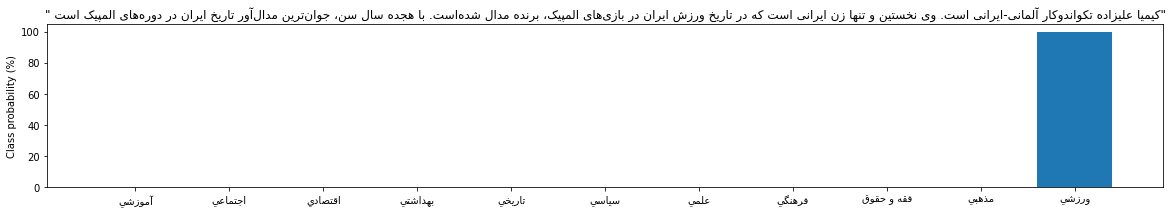

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد اما مدل آن را به عنوان خبر آموزشی تشخیص داده است.

In [ ]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.4733266234397888},
  {'label': 'LABEL_1', 'score': 0.013712555170059204},
  {'label': 'LABEL_2', 'score': 0.0040684593841433525},
  {'label': 'LABEL_3', 'score': 0.007379855494946241},
  {'label': 'LABEL_4', 'score': 0.003840853227302432},
  {'label': 'LABEL_5', 'score': 0.0030409765895456076},
  {'label': 'LABEL_6', 'score': 0.47366440296173096},
  {'label': 'LABEL_7', 'score': 0.010405405424535275},
  {'label': 'LABEL_8', 'score': 0.0038077575154602528},
  {'label': 'LABEL_9', 'score': 0.0020493881311267614},
  {'label': 'LABEL_10', 'score': 0.004703668411821127}]]

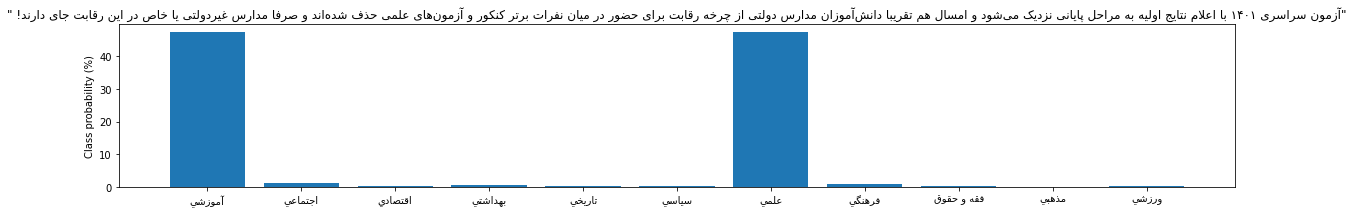

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## Hyperparameter search (ParsBERT V03)

### Tokenizing the whole dataset

In [ ]:
#this time we use parsbert v03
model_name = 'HooshvareLab/bert-fa-zwnj-base'
num_labels = 11

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='HooshvareLab/bert-fa-zwnj-base', vocab_size=42000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.vocab_size

42000

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [ ]:
print(tokenize(dataset["train"][0]))

{'input_ids': [2, 1923, 2459, 2549, 9034, 1173, 7460, 22144, 1125, 7268, 2754, 115, 7268, 6227, 1110, 116, 1923, 3470, 1925, 2549, 9034, 1173, 595, 6791, 1121, 4124, 1124, 5971, 590, 7277, 40832, 20928, 590, 7683, 9403, 1987, 9, 625, 4937, 1173, 2060, 9905, 1921, 3434, 7683, 9403, 1124, 2211, 2127, 1925, 1, 9, 41902, 1118, 1173, 1921, 3355, 9, 7268, 1923, 1, 4937, 1173, 4909, 1969, 3378, 133, 1921, 2574, 3255, 2806, 1984, 1921, 1, 1951, 1173, 2556, 1921, 2081, 1118, 1173, 8737, 23266, 1123, 1, 1, 9, 1953, 623, 4109, 9403, 10783, 31316, 9, 2250, 1937, 8572, 2206, 9, 1953, 121, 623, 1173, 1, 1921, 2078, 2917, 1921, 9905, 1927, 4451, 3251, 9, 7268, 2415, 7177, 1969, 1923, 3009, 10949, 3899, 1173, 3704, 1983, 1933, 590, 4498, 1, 1, 1, 2127, 1925, 6289, 597, 1173, 9, 8831, 1173, 9, 2113, 3896, 34329, 1969, 1937, 6365, 1925, 2038, 620, 1173, 9, 41902, 1938, 121, 3624, 1934, 2038, 22228, 9403, 1173, 623, 1173, 1923, 2179, 4055, 1, 4937, 1173, 2060, 1921, 3434, 7683, 9403, 1124, 2211, 3949, 23

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-5eaa4017127dd6a5/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-fe76759a61e746e3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-5eaa4017127dd6a5/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-4969c7acf74f1f27.arrow


In [ ]:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [ ]:
! pip install -q optuna
! pip install -q ray[tune]

### Fine-Tunning Transformers

During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [ ]:
from transformers import AutoModelForSequenceClassification
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

### Training the model

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_encoded["train"]) // batch_size
model_path = f"/content/drive/MyDrive/HW5/{model_name}-finetuned-persika"
training_args = TrainingArguments(output_dir=model_path,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

And we can instantiate our `Trainer` like before:

The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
train_dataset = dataset_encoded["train"].shard(index=1, num_shards=10) 

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 879
})

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dataset_encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2022-08-05 03:58:29,555] A new study created in memory with name: no-name-a1b25402-f0c0-4751-bbe2-f216b28b70f9


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.054574,0.409463,0.327475


[I 2022-08-05 04:01:21,915] Trial 0 finished with value: 0.7369378249298162 and parameters: {'learning_rate': 2.438872206864296e-05, 'num_train_epochs': 1, 'seed': 17, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.7369378249298162.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.293765,0.218835,0.158449


[I 2022-08-05 04:04:14,049] Trial 1 finished with value: 0.37728419982391126 and parameters: {'learning_rate': 8.971475170506652e-06, 'num_train_epochs': 1, 'seed': 10, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.7369378249298162.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.879977,0.500000,0.437063


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.879977,0.500000,0.437063
2,No log,1.283735,0.716106,0.696641
3,No log,1.020633,0.754322,0.739402
4,No log,0.912507,0.768426,0.758196
5,No log,0.889045,0.775250,0.767980


[I 2022-08-05 04:18:32,832] Trial 2 finished with value: 1.5432303482357084 and parameters: {'learning_rate': 8.605615563694513e-06, 'num_train_epochs': 5, 'seed': 24, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 1.5432303482357084.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.252939,0.252047,0.192052
2,No log,2.161174,0.325296,0.286984


[I 2022-08-05 04:24:14,705] Trial 3 finished with value: 0.6122796011429227 and parameters: {'learning_rate': 5.8699973597713505e-06, 'num_train_epochs': 2, 'seed': 38, 'per_device_train_batch_size': 8}. Best is trial 2 with value: 1.5432303482357084.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.396477,0.109645,0.063106


[I 2022-08-05 04:27:06,620] Trial 4 finished with value: 0.172751536861875 and parameters: {'learning_rate': 1.2162272924683995e-06, 'num_train_epochs': 1, 'seed': 21, 'per_device_train_batch_size': 4}. Best is trial 2 with value: 1.5432303482357084.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.929959,0.725660,0.720307
2,No log,0.855173,0.747498,0.752318
3,No log,0.808148,0.783894,0.783882


[I 2022-08-05 04:35:38,734] Trial 5 finished with value: 1.5677767066162218 and parameters: {'learning_rate': 8.672369708045883e-05, 'num_train_epochs': 3, 'seed': 24, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 1.5677767066162218.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.353379,0.151501,0.124906


[I 2022-08-05 04:38:30,609] Trial 6 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.350268,0.648317,0.614173


[I 2022-08-05 04:41:22,209] Trial 7 finished with value: 1.2624899139491663 and parameters: {'learning_rate': 6.763906727811519e-05, 'num_train_epochs': 1, 'seed': 1, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 1.5677767066162218.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.274900,0.297088,0.238584


[I 2022-08-05 04:44:13,796] Trial 8 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.778023,0.538672,0.500878
2,No log,1.371753,0.681074,0.654866


[I 2022-08-05 04:49:55,772] Trial 9 pruned. 


The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [ ]:
best_run

BestRun(run_id='5', objective=1.5677767066162218, hyperparameters={'learning_rate': 8.672369708045883e-05, 'num_train_epochs': 3, 'seed': 24, 'per_device_train_batch_size': 16})

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

Now we should train over whole of the dataset.

In [ ]:
# from transformers import AutoModelForSequenceClassification

# num_labels = 11
# model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True).to(device))

In [ ]:
trainer.train_dataset = dataset_encoded["train"]

In [ ]:
trainer.train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8790
})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.859000,0.634514,0.824386,0.823171
2,0.463300,0.625492,0.855778,0.854497
3,0.256800,0.658601,0.867152,0.866009


TrainOutput(global_step=3297, training_loss=0.5259918703033521, metrics={'train_runtime': 2992.6767, 'train_samples_per_second': 8.812, 'train_steps_per_second': 1.102, 'total_flos': 7660044870638592.0, 'train_loss': 0.5259918703033521, 'epoch': 3.0})

### Evaluation on the Test set

In [ ]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [ ]:
preds_output_test.metrics

{'test_accuracy': 0.8671519563239308,
 'test_f1': 0.8660089394382317,
 'test_loss': 0.6586011052131653,
 'test_runtime': 80.1932,
 'test_samples_per_second': 27.409,
 'test_steps_per_second': 3.429}

In [ ]:
y_test = np.array(dataset_encoded["test"]["label"])

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

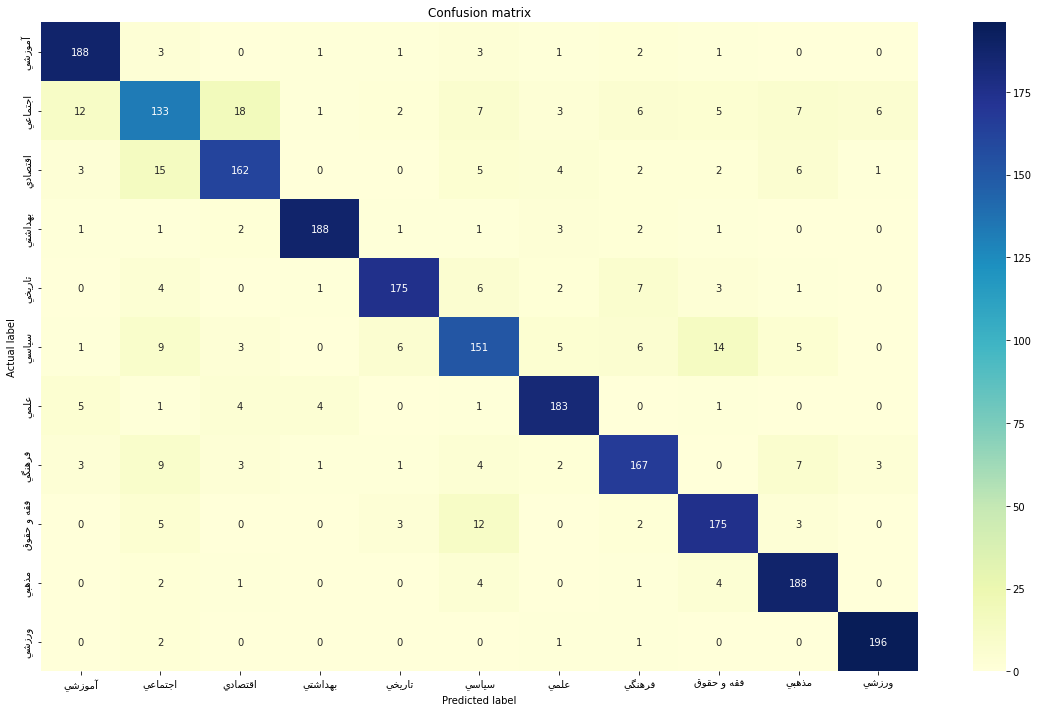

In [ ]:
confusion_matrix(y_test, y_preds_test)

In [ ]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.88      0.94      0.91       200\n           1       0.72      0.67      0.69       200\n           2       0.84      0.81      0.82       200\n           3       0.96      0.94      0.95       200\n           4       0.93      0.88      0.90       199\n           5       0.78      0.76      0.77       200\n           6       0.90      0.92      0.91       199\n           7       0.85      0.83      0.84       200\n           8       0.85      0.88      0.86       200\n           9       0.87      0.94      0.90       200\n          10       0.95      0.98      0.97       200\n\n    accuracy                           0.87      2198\n   macro avg       0.87      0.87      0.87      2198\nweighted avg       0.87      0.87      0.87      2198\n'

In [ ]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,8.826341
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,8.178761
465,به گزارش اداره كل روابط عمومي و بين‌الملل شهرد...,سياسي,اجتماعي,8.159173
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,8.069651
2188,برنامه كارگاه آموزش عملي دانشكده علوم دانشگاه ...,سياسي,علمي,7.996334
965,مشاور رييس دولت امارات گفت: سيره‌ي پيامبر (ص) ...,مذهبي,فقه و حقوق,7.844840
3,به گزارش خبرنگار خبرگزاري دانشجويان ايران (ايس...,فرهنگي,بهداشتي,7.771376
714,به گزارش ايسنا، پژوهشگران از رشد سريع ماهواره‌...,اجتماعي,علمي,7.764572
66,به گزارش گروه دريافت خبر “ايسنا“، يك مقام مسوو...,اقتصادي,علمي,7.760775
1553,به گزارش ايسنا، به نقل ازروابط عمومي وزارت بهد...,اجتماعي,بهداشتي,7.712973


### Test the pipeline with a sample news

In [ ]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/HW5/content/drive/MyDrive/HW5/HooshvareLab/bert-fa-zwnj-base-finetuned-persika-finetuned-persika/checkpoint-3000"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

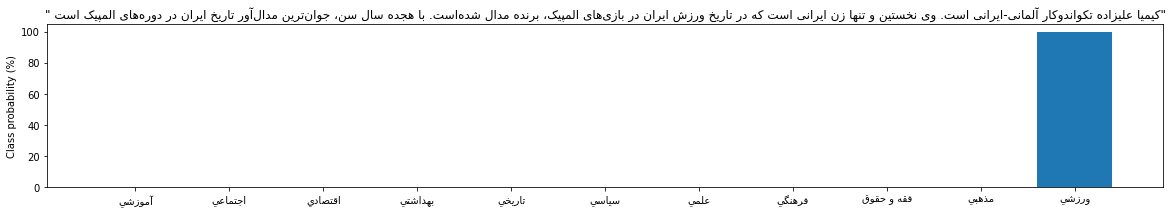

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد و مدل به درستی آن را به عنوان خبر آموزشی تشخیص داده است.

In [ ]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.026021404191851616},
  {'label': 'LABEL_1', 'score': 0.9401021003723145},
  {'label': 'LABEL_2', 'score': 0.0005383588140830398},
  {'label': 'LABEL_3', 'score': 0.0014137368416413665},
  {'label': 'LABEL_4', 'score': 0.0020985144656151533},
  {'label': 'LABEL_5', 'score': 0.00951453484594822},
  {'label': 'LABEL_6', 'score': 0.015100630931556225},
  {'label': 'LABEL_7', 'score': 0.0015849546762183309},
  {'label': 'LABEL_8', 'score': 0.0004744895559269935},
  {'label': 'LABEL_9', 'score': 0.0006293277256190777},
  {'label': 'LABEL_10', 'score': 0.002521906513720751}]]

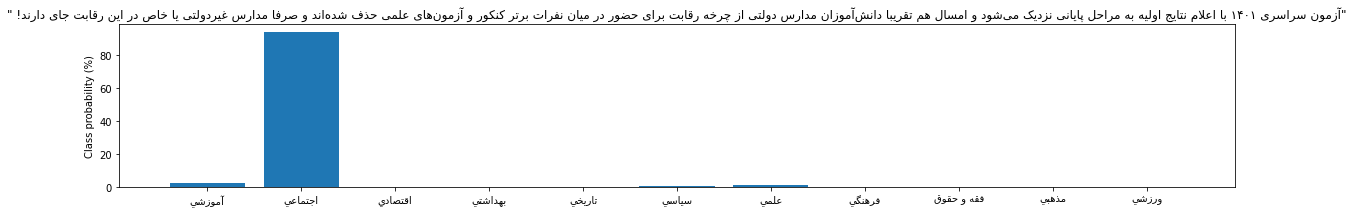

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

### Train a new model using best parameters

In [ ]:
best_run.hyperparameters.items()

dict_items([('learning_rate', 8.672369708045883e-05), ('num_train_epochs', 3), ('seed', 24), ('per_device_train_batch_size', 16)])

In [ ]:
# f = open("/content/drive/MyDrive/HW5/best_run.hyperparameters.pkl","wb")

# # write the python object (dict) to pickle file
# pickle.dump(list(best_run.hyperparameters.items()),f)

# # close file
# f.close()

In [ ]:
with open('/content/drive/MyDrive/HW5/best_run.hyperparameters.pkl', 'rb') as f:
    best_run_hyperparameters = pickle.load(f)

In [ ]:
best_run_hyperparameters = dict(best_run_hyperparameters)
best_run_hyperparameters.items()

dict_items([('learning_rate', 8.672369708045883e-05), ('num_train_epochs', 3), ('seed', 24), ('per_device_train_batch_size', 16)])

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 11
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True).to(device))

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/b

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)

using best parameters

In [ ]:
for n, v in best_run_hyperparameters.items():
    setattr(trainer.args, n, v)

In [ ]:
trainer.args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_names=None,
label_s

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  463628 KB |  463628 KB |  463628 KB |       0 B  |\n|       from large pool |  463104 KB |  463104 KB |  463104 KB |       0 B  |\n|       from small pool |     524 KB |     524 KB |     524 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  463628 KB |  463628 KB |  463628 KB |       0 B  |\n|       from large pool |  463104 KB |  463104 KB |

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.900700,0.684796,0.813467,0.819589
2,0.459100,0.601566,0.850318,0.850293
3,0.250600,0.651735,0.866697,0.866343


TrainOutput(global_step=3297, training_loss=0.5363473108465975, metrics={'train_runtime': 2993.5082, 'train_samples_per_second': 8.809, 'train_steps_per_second': 1.101, 'total_flos': 6938799190640640.0, 'train_loss': 0.5363473108465975, 'epoch': 3.0})

### Evaluation on the Test set

In [ ]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [ ]:
preds_output_test.metrics

{'test_accuracy': 0.8666969972702456,
 'test_f1': 0.8663429638091893,
 'test_loss': 0.6517351865768433,
 'test_runtime': 80.1533,
 'test_samples_per_second': 27.422,
 'test_steps_per_second': 3.431}

In [ ]:
y_test = np.array(dataset_encoded["test"]["label"])

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

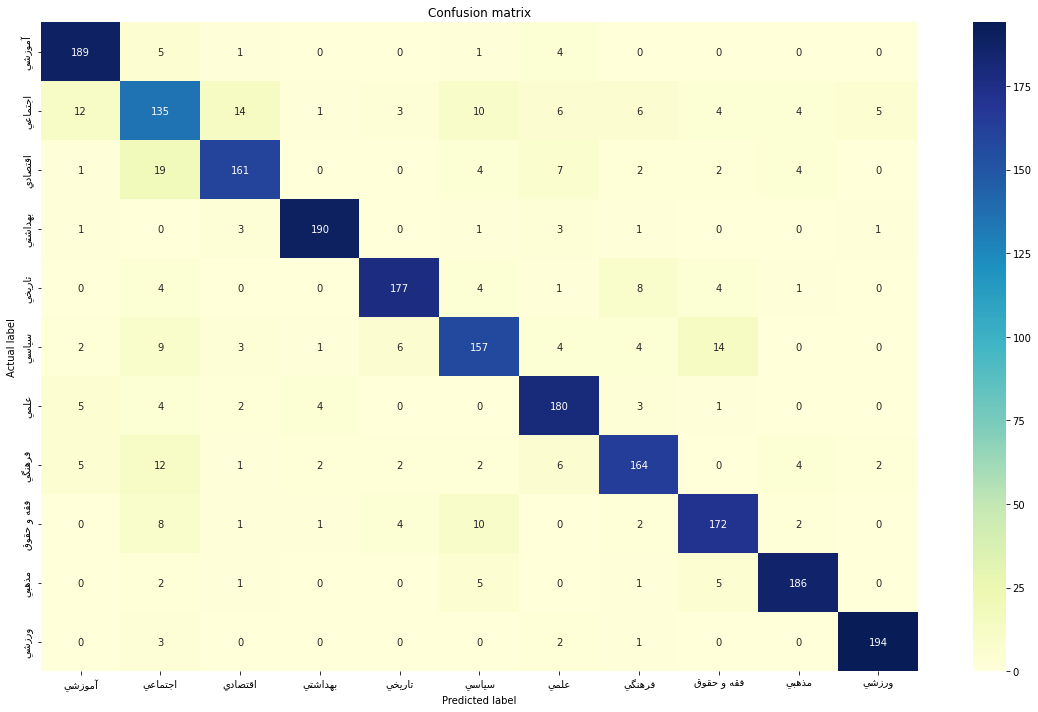

In [ ]:
confusion_matrix(y_test, y_preds_test)

In [ ]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.88      0.94      0.91       200\n           1       0.67      0.68      0.67       200\n           2       0.86      0.81      0.83       200\n           3       0.95      0.95      0.95       200\n           4       0.92      0.89      0.91       199\n           5       0.81      0.79      0.80       200\n           6       0.85      0.90      0.87       199\n           7       0.85      0.82      0.84       200\n           8       0.85      0.86      0.86       200\n           9       0.93      0.93      0.93       200\n          10       0.96      0.97      0.97       200\n\n    accuracy                           0.87      2198\n   macro avg       0.87      0.87      0.87      2198\nweighted avg       0.87      0.87      0.87      2198\n'

In [ ]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask",
"label"])
# Compute loss values
dataset_encoded["test"] = dataset_encoded["test"].map(
  forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/138 [00:00<?, ?ba/s]

In [ ]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,9.703139
1653,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,بهداشتي,فرهنگي,9.572515
2188,برنامه كارگاه آموزش عملي دانشكده علوم دانشگاه ...,سياسي,علمي,9.354598
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,9.343635
643,حوزه علميه خراسان با صدور بيانيه‌اي از امت شهي...,فقه و حقوق,تاريخي,9.066263
333,اداره كل فرهنگ و ارشاد اسلامي استان قم در راست...,فقه و حقوق,فرهنگي,8.860208
1218,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، شور...,فقه و حقوق,مذهبي,8.775072
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,8.753297
2170,به گزارش خبرنگار سرويس تلويزيون ايسنا اين كنفر...,فرهنگي,علمي,8.703876
1625,همچنين مراسم بزرگداشت آيت الله خاتمي بعد از ظه...,اجتماعي,تاريخي,8.699543


### Test the pipeline with a sample news

In [ ]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/HW5/HooshvareLab/bert-fa-zwnj-base-finetuned-persika/checkpoint-3000"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

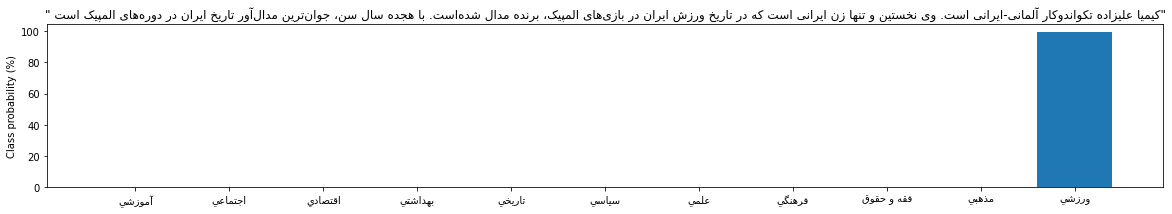

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد و مدل به درستی آن را به عنوان خبر آموزشی تشخیص داده است.

In [ ]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.06198898330330849},
  {'label': 'LABEL_1', 'score': 0.14407071471214294},
  {'label': 'LABEL_2', 'score': 0.006173143163323402},
  {'label': 'LABEL_3', 'score': 0.002321407198905945},
  {'label': 'LABEL_4', 'score': 0.0019721679855138063},
  {'label': 'LABEL_5', 'score': 0.007209055591374636},
  {'label': 'LABEL_6', 'score': 0.7700656652450562},
  {'label': 'LABEL_7', 'score': 0.001814096001908183},
  {'label': 'LABEL_8', 'score': 0.0005761241191066802},
  {'label': 'LABEL_9', 'score': 0.001267148181796074},
  {'label': 'LABEL_10', 'score': 0.002541471039876342}]]

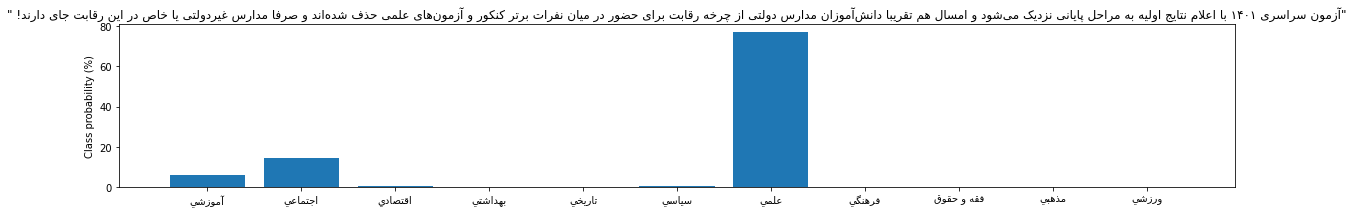

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## Text Classification using Multilingula Model 1

bert-base-multilingual-cased (104 languages)

### Tokenizing the whole dataset

In [25]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [26]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [27]:
tokenizer.vocab_size

119547

In [28]:
tokenizer.model_max_length

512

In [29]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [30]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [31]:
print(tokenize(dataset["train"][0]))

{'input_ids': [101, 10327, 77976, 73618, 15570, 34648, 10461, 82920, 54731, 44085, 763, 15089, 10765, 113, 763, 25563, 14695, 114, 10327, 34893, 10383, 73618, 15570, 34648, 10461, 758, 81719, 56363, 10502, 10658, 49045, 11091, 752, 13044, 10700, 35640, 20109, 752, 789, 14495, 11294, 13678, 10461, 768, 31522, 47814, 770, 14556, 10388, 766, 15570, 88919, 10239, 20529, 789, 14495, 11294, 10658, 23363, 15326, 10383, 786, 14695, 22900, 15570, 106304, 10239, 12995, 10742, 10461, 10327, 16079, 53505, 10765, 768, 31522, 47814, 16498, 14556, 10388, 13001, 59658, 17444, 131, 10239, 20323, 26294, 31789, 10289, 10239, 786, 25863, 22900, 16079, 89218, 10388, 10239, 788, 31190, 10461, 763, 61783, 19445, 88894, 26292, 769, 10673, 12497, 10502, 786, 21172, 72403, 791, 785, 84577, 28340, 42744, 11294, 20208, 10748, 30872, 34353, 25772, 13367, 119, 791, 10461, 786, 10388, 10239, 22848, 49766, 10239, 766, 15570, 88919, 10909, 771, 98273, 14431, 10461, 13290, 13001, 10327, 57623, 766, 23927, 11086, 42309,

In [32]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


### Fine-Tunning Transformers

You will see a warning that some parts of the model are randomly initialized.
This is normal since the classification head has not yet been trained. The n

In [34]:
from transformers import AutoModelForSequenceClassification

num_labels = 11
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True).to(device))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [35]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Training the model

In [36]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"/content/drive/MyDrive/HW5/{model_ckpt}-finetuned-persika"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [37]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)

In [38]:
import torch
torch.cuda.empty_cache()

In [39]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  695052 KB |  695052 KB |  695052 KB |       0 B  |\n|       from large pool |  694528 KB |  694528 KB |  694528 KB |       0 B  |\n|       from small pool |     524 KB |     524 KB |     524 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  695052 KB |  695052 KB |  695052 KB |       0 B  |\n|       from large pool |  694528 KB |  694528 KB |

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.862600,0.556430,0.847589,0.847272
2,0.415700,0.503884,0.878526,0.877499


TrainOutput(global_step=2198, training_loss=0.639145439000863, metrics={'train_runtime': 2087.4239, 'train_samples_per_second': 8.422, 'train_steps_per_second': 1.053, 'total_flos': 4625866127093760.0, 'train_loss': 0.639145439000863, 'epoch': 2.0})

### Evaluation on the Test set

In [41]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [42]:
preds_output_test.metrics

{'test_accuracy': 0.87852593266606,
 'test_f1': 0.8774990027575185,
 'test_loss': 0.5038840174674988,
 'test_runtime': 80.7033,
 'test_samples_per_second': 27.236,
 'test_steps_per_second': 3.408}

In [43]:
y_test = np.array(dataset_encoded["test"]["label"])

In [44]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

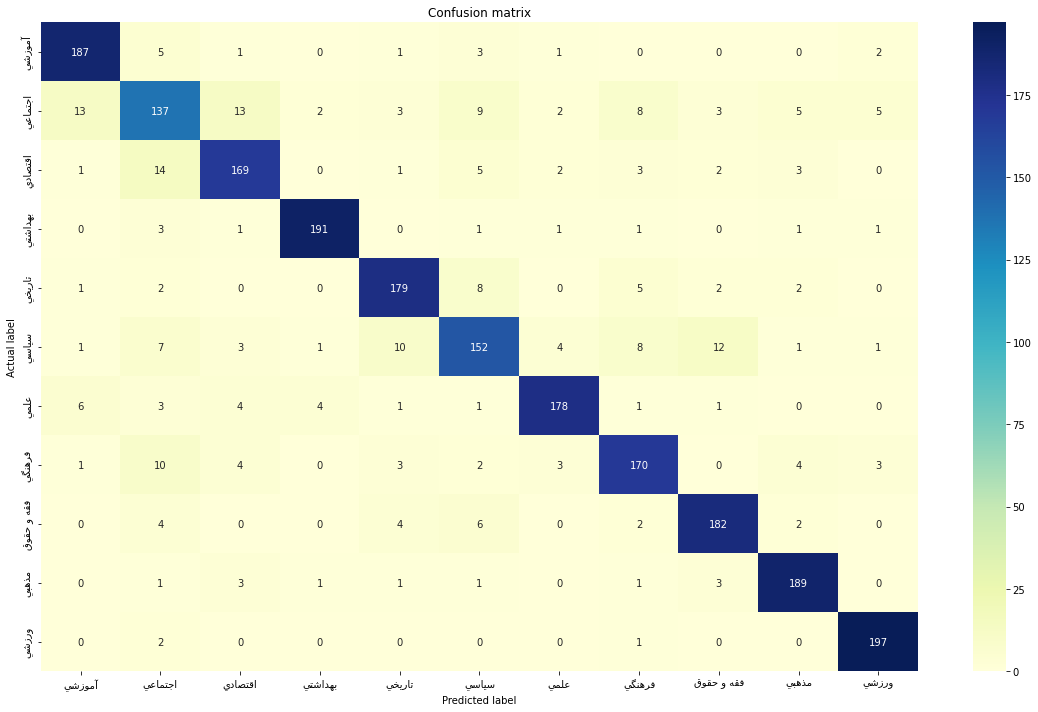

In [45]:
confusion_matrix(y_test, y_preds_test)

In [46]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.89      0.94      0.91       200\n           1       0.73      0.69      0.71       200\n           2       0.85      0.84      0.85       200\n           3       0.96      0.95      0.96       200\n           4       0.88      0.90      0.89       199\n           5       0.81      0.76      0.78       200\n           6       0.93      0.89      0.91       199\n           7       0.85      0.85      0.85       200\n           8       0.89      0.91      0.90       200\n           9       0.91      0.94      0.93       200\n          10       0.94      0.98      0.96       200\n\n    accuracy                           0.88      2198\n   macro avg       0.88      0.88      0.88      2198\nweighted avg       0.88      0.88      0.88      2198\n'

In [47]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask",
"label"])
# Compute loss values
dataset_encoded["test"] = dataset_encoded["test"].map(
  forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/138 [00:00<?, ?ba/s]

In [48]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [49]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1922,به گزارش ايسنا سخنراني رييس كل سازمان نظام پرس...,بهداشتي,مذهبي,7.626729
2089,ميشل بالاك اخيرا در شهر ژنو سمت نمايندگي ويژه ...,اجتماعي,ورزشي,7.245378
1017,رييس مركز اسلامي سنگال، در چارچوب ايجاد وحدت م...,مذهبي,فقه و حقوق,7.222730
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,7.160265
965,مشاور رييس دولت امارات گفت: سيره‌ي پيامبر (ص) ...,مذهبي,فقه و حقوق,7.159337
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,7.060215
1601,به گزارش ايسنا، “دكتر جلالي“ گفت: اين همايش كا...,علمي,اقتصادي,6.859211
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,6.755641
528,ايلام در زمان باستان به اريوجان شهرت داشته است...,اقتصادي,تاريخي,6.753309
623,به گزارش گروه دريافت خبر ايسنا، حسين عباس‌زاده...,فرهنگي,اقتصادي,6.752096


### Test the pipeline with a sample news

In [50]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/HW5/bert-base-multilingual-cased-finetuned-persika/checkpoint-2000"
classifier = pipeline("text-classification", model=model_id)

In [51]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

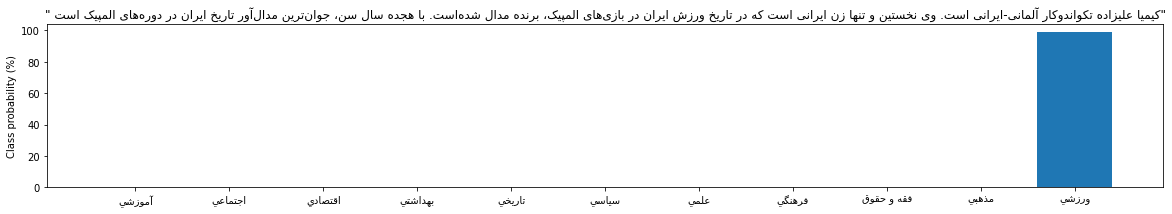

In [53]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد و مدل آن را به عنوان خبر اجتماعی تشخیص داده است.

In [54]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [55]:
preds

[[{'label': 'LABEL_0', 'score': 0.05056695267558098},
  {'label': 'LABEL_1', 'score': 0.6678404211997986},
  {'label': 'LABEL_2', 'score': 0.04229394346475601},
  {'label': 'LABEL_3', 'score': 0.010405258275568485},
  {'label': 'LABEL_4', 'score': 0.005739601328969002},
  {'label': 'LABEL_5', 'score': 0.016160544008016586},
  {'label': 'LABEL_6', 'score': 0.06851272284984589},
  {'label': 'LABEL_7', 'score': 0.007948423735797405},
  {'label': 'LABEL_8', 'score': 0.010999166406691074},
  {'label': 'LABEL_9', 'score': 0.017674529924988747},
  {'label': 'LABEL_10', 'score': 0.10185853391885757}]]

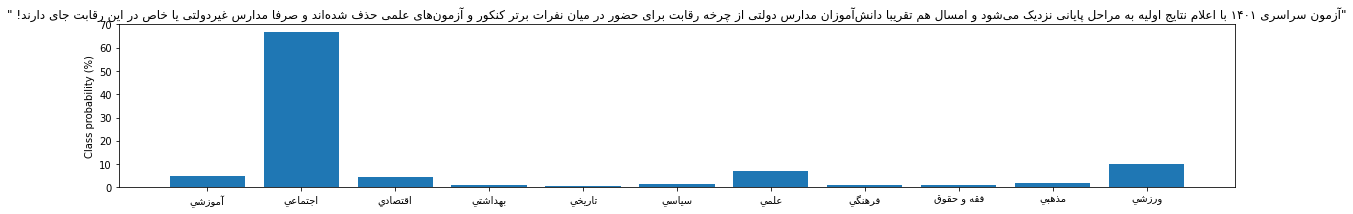

In [56]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## Text Classification using Multilingual Model1(time2)

bert-base-multilingual-cased (104 languages)

### Tokenizing the whole dataset

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.vocab_size

119547

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [ ]:
print(tokenize(dataset["train"][0]))

{'input_ids': [101, 10327, 77976, 73618, 15570, 34648, 10461, 82920, 54731, 44085, 763, 15089, 10765, 113, 763, 25563, 14695, 114, 10327, 34893, 10383, 73618, 15570, 34648, 10461, 758, 81719, 56363, 10502, 10658, 49045, 11091, 752, 13044, 10700, 35640, 20109, 752, 789, 14495, 11294, 13678, 10461, 768, 31522, 47814, 770, 14556, 10388, 766, 15570, 88919, 10239, 20529, 789, 14495, 11294, 10658, 23363, 15326, 10383, 786, 14695, 22900, 15570, 106304, 10239, 12995, 10742, 10461, 10327, 16079, 53505, 10765, 768, 31522, 47814, 16498, 14556, 10388, 13001, 59658, 17444, 131, 10239, 20323, 26294, 31789, 10289, 10239, 786, 25863, 22900, 16079, 89218, 10388, 10239, 788, 31190, 10461, 763, 61783, 19445, 88894, 26292, 769, 10673, 12497, 10502, 786, 21172, 72403, 791, 785, 84577, 28340, 42744, 11294, 20208, 10748, 30872, 34353, 25772, 13367, 119, 791, 10461, 786, 10388, 10239, 22848, 49766, 10239, 766, 15570, 88919, 10909, 771, 98273, 14431, 10461, 13290, 13001, 10327, 57623, 766, 23927, 11086, 42309,

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


### Fine-Tunning Transformers

You will see a warning that some parts of the model are randomly initialized.
This is normal since the classification head has not yet been trained. The n

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 11
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True).to(device))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Training the model

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"/content/drive/MyDrive/HW5/{model_ckpt}-finetuned-persika"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  695052 KB |  695052 KB |  695052 KB |       0 B  |\n|       from large pool |  694528 KB |  694528 KB |  694528 KB |       0 B  |\n|       from small pool |     524 KB |     524 KB |     524 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  695052 KB |  695052 KB |  695052 KB |       0 B  |\n|       from large pool |  694528 KB |  694528 KB |

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.862600,0.556430,0.847589,0.847272
2,0.415700,0.503884,0.878526,0.877499


TrainOutput(global_step=2198, training_loss=0.639145439000863, metrics={'train_runtime': 2087.4239, 'train_samples_per_second': 8.422, 'train_steps_per_second': 1.053, 'total_flos': 4625866127093760.0, 'train_loss': 0.639145439000863, 'epoch': 2.0})

### Evaluation on the Test set

In [ ]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [ ]:
preds_output_test.metrics

{'test_accuracy': 0.87852593266606,
 'test_f1': 0.8774990027575185,
 'test_loss': 0.5038840174674988,
 'test_runtime': 80.7033,
 'test_samples_per_second': 27.236,
 'test_steps_per_second': 3.408}

In [ ]:
y_test = np.array(dataset_encoded["test"]["label"])

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

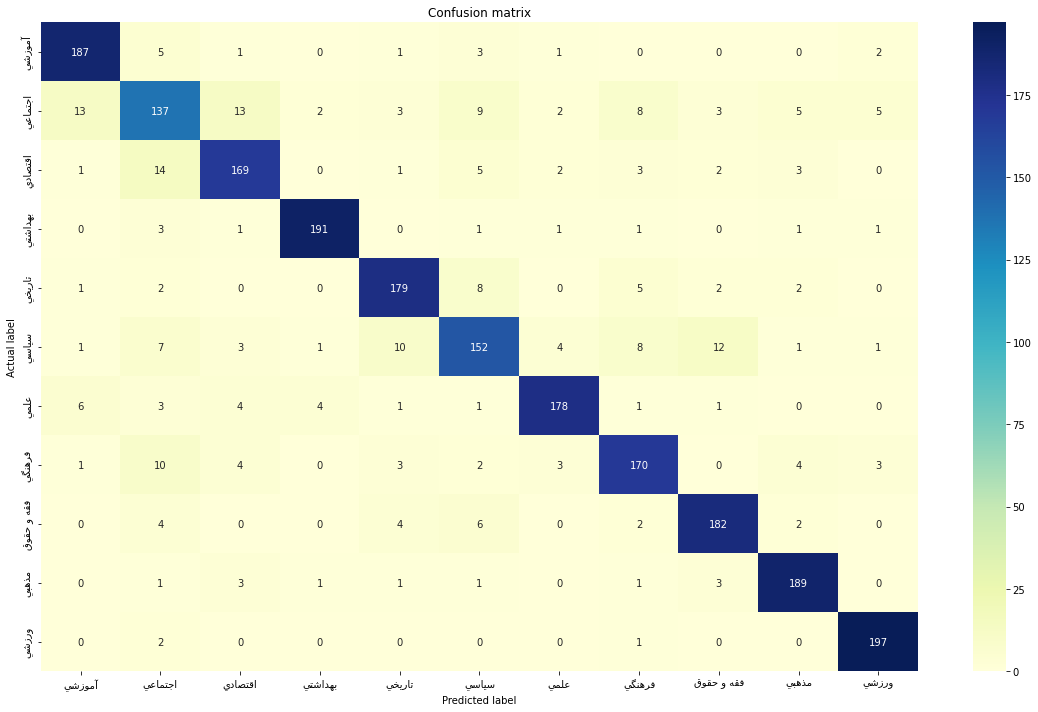

In [ ]:
confusion_matrix(y_test, y_preds_test)

In [ ]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.89      0.94      0.91       200\n           1       0.73      0.69      0.71       200\n           2       0.85      0.84      0.85       200\n           3       0.96      0.95      0.96       200\n           4       0.88      0.90      0.89       199\n           5       0.81      0.76      0.78       200\n           6       0.93      0.89      0.91       199\n           7       0.85      0.85      0.85       200\n           8       0.89      0.91      0.90       200\n           9       0.91      0.94      0.93       200\n          10       0.94      0.98      0.96       200\n\n    accuracy                           0.88      2198\n   macro avg       0.88      0.88      0.88      2198\nweighted avg       0.88      0.88      0.88      2198\n'

In [ ]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask",
"label"])
# Compute loss values
dataset_encoded["test"] = dataset_encoded["test"].map(
  forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/138 [00:00<?, ?ba/s]

In [ ]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1922,به گزارش ايسنا سخنراني رييس كل سازمان نظام پرس...,بهداشتي,مذهبي,7.626729
2089,ميشل بالاك اخيرا در شهر ژنو سمت نمايندگي ويژه ...,اجتماعي,ورزشي,7.245378
1017,رييس مركز اسلامي سنگال، در چارچوب ايجاد وحدت م...,مذهبي,فقه و حقوق,7.222730
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,7.160265
965,مشاور رييس دولت امارات گفت: سيره‌ي پيامبر (ص) ...,مذهبي,فقه و حقوق,7.159337
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,7.060215
1601,به گزارش ايسنا، “دكتر جلالي“ گفت: اين همايش كا...,علمي,اقتصادي,6.859211
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,6.755641
528,ايلام در زمان باستان به اريوجان شهرت داشته است...,اقتصادي,تاريخي,6.753309
623,به گزارش گروه دريافت خبر ايسنا، حسين عباس‌زاده...,فرهنگي,اقتصادي,6.752096


### Test the pipeline with a sample news

In [ ]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/HW5/bert-base-multilingual-cased-finetuned-persika/checkpoint-2000"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

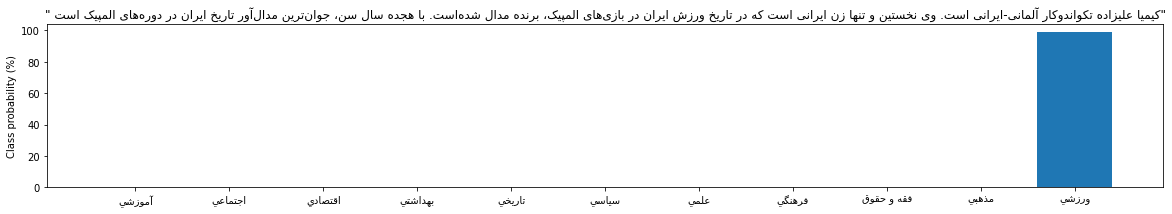

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد و مدل آن را به عنوان خبر اجتماعی تشخیص داده است.

In [ ]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.05056695267558098},
  {'label': 'LABEL_1', 'score': 0.6678404211997986},
  {'label': 'LABEL_2', 'score': 0.04229394346475601},
  {'label': 'LABEL_3', 'score': 0.010405258275568485},
  {'label': 'LABEL_4', 'score': 0.005739601328969002},
  {'label': 'LABEL_5', 'score': 0.016160544008016586},
  {'label': 'LABEL_6', 'score': 0.06851272284984589},
  {'label': 'LABEL_7', 'score': 0.007948423735797405},
  {'label': 'LABEL_8', 'score': 0.010999166406691074},
  {'label': 'LABEL_9', 'score': 0.017674529924988747},
  {'label': 'LABEL_10', 'score': 0.10185853391885757}]]

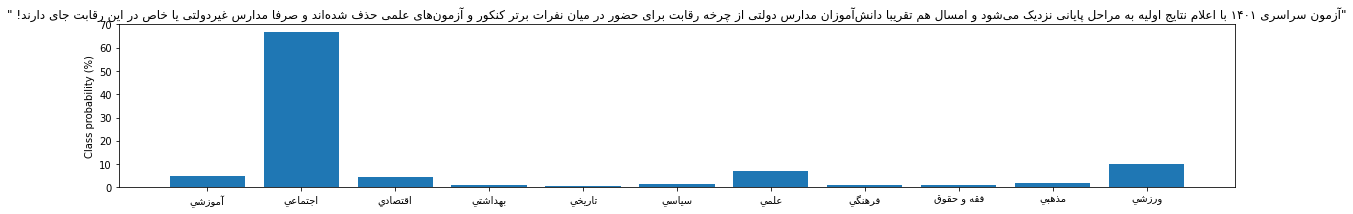

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## Text Classification using Multilingual Model2

bert-base-multilingual-uncased (102 languages)

### Tokenizing the whole dataset

In [15]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-multilingual-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [16]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [17]:
tokenizer.vocab_size

105879

In [18]:
tokenizer.model_max_length

512

In [19]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [20]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [21]:
print(tokenize(dataset["train"][0]))

{'input_ids': [101, 10364, 74236, 70041, 15639, 35271, 10521, 78568, 49729, 46455, 28469, 113, 17781, 36647, 10383, 114, 10364, 34338, 10427, 70041, 15639, 35271, 10521, 11844, 26880, 29759, 10727, 66127, 11206, 446, 13351, 10720, 35476, 19934, 446, 477, 14723, 11387, 13408, 10521, 456, 29574, 44316, 458, 14362, 10411, 454, 15639, 51153, 10266, 20805, 477, 14723, 11387, 10727, 23167, 15677, 10427, 474, 14636, 22011, 15639, 69921, 10266, 13275, 10797, 10521, 10364, 16264, 51563, 10872, 456, 29574, 44316, 16124, 14362, 10411, 13283, 56748, 17699, 131, 10266, 20618, 26555, 31745, 10332, 10266, 474, 25509, 22011, 16264, 47337, 10411, 10266, 476, 26599, 10521, 451, 40484, 19272, 84103, 25606, 457, 10769, 12570, 10558, 474, 21478, 63771, 479, 473, 80627, 27682, 40310, 11387, 18373, 10856, 30763, 41644, 25823, 13279, 119, 479, 10521, 474, 10411, 10266, 23132, 48637, 10266, 454, 15639, 51153, 11045, 459, 11872, 74980, 10521, 13590, 13283, 10364, 55989, 454, 22274, 11179, 41486, 10521, 476, 793

In [22]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [23]:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


### Fine-Tunning Transformers

You will see a warning that some parts of the model are randomly initialized.
This is normal since the classification head has not yet been trained. The n

In [24]:
from transformers import AutoModelForSequenceClassification

num_labels = 11
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True).to(device))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [25]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Training the model

In [28]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"/content/drive/MyDrive/HW5/{model_ckpt}-finetuned-persika"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [29]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)

In [30]:
import torch
torch.cuda.empty_cache()

In [31]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  654092 KB |  654092 KB |  654092 KB |       0 B  |\n|       from large pool |  653568 KB |  653568 KB |  653568 KB |       0 B  |\n|       from small pool |     524 KB |     524 KB |     524 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  654092 KB |  654092 KB |  654092 KB |       0 B  |\n|       from large pool |  653568 KB |  653568 KB |

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.889600,0.559677,0.837125,0.841280


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.889600,0.559677,0.837125,0.841280
2,0.436000,0.492757,0.871702,0.871501
3,0.299400,0.501759,0.885805,0.885511


TrainOutput(global_step=3297, training_loss=0.5412294517819506, metrics={'train_runtime': 3122.3226, 'train_samples_per_second': 8.446, 'train_steps_per_second': 1.056, 'total_flos': 6938799190640640.0, 'train_loss': 0.5412294517819506, 'epoch': 3.0})

### Evaluation on the Test set

In [33]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [34]:
preds_output_test.metrics

{'test_accuracy': 0.8858052775250227,
 'test_f1': 0.8855106772372491,
 'test_loss': 0.5017591714859009,
 'test_runtime': 81.4383,
 'test_samples_per_second': 26.99,
 'test_steps_per_second': 3.377}

In [35]:
y_test = np.array(dataset_encoded["test"]["label"])

In [36]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

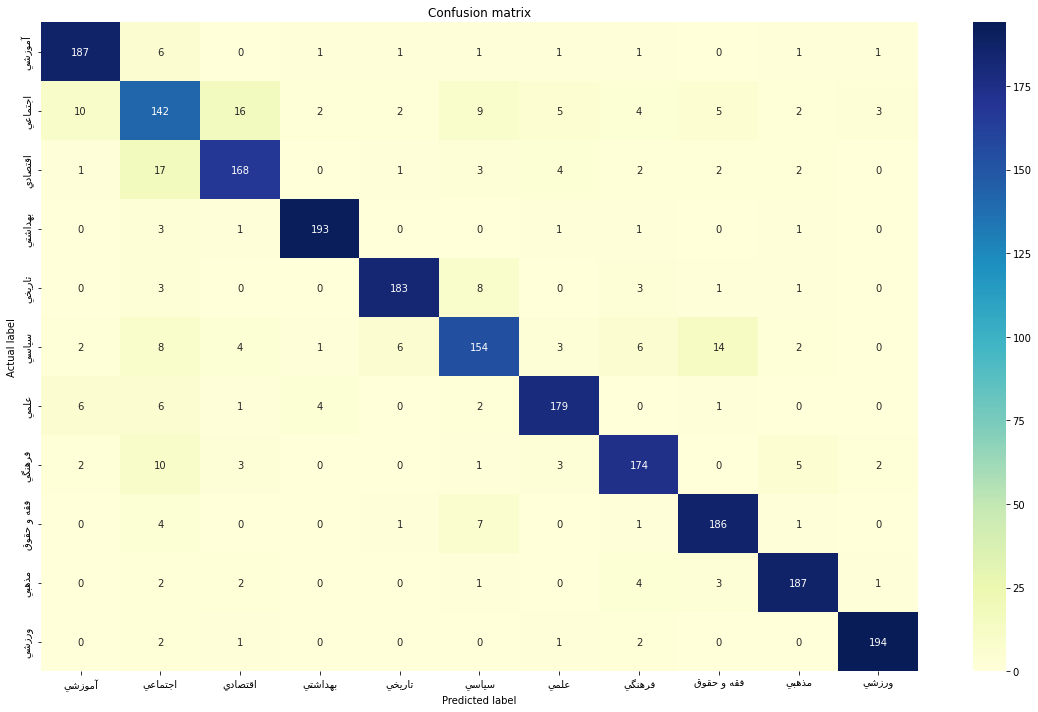

In [37]:
confusion_matrix(y_test, y_preds_test)

In [42]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.90      0.94      0.92       200\n           1       0.70      0.71      0.70       200\n           2       0.86      0.84      0.85       200\n           3       0.96      0.96      0.96       200\n           4       0.94      0.92      0.93       199\n           5       0.83      0.77      0.80       200\n           6       0.91      0.90      0.90       199\n           7       0.88      0.87      0.87       200\n           8       0.88      0.93      0.90       200\n           9       0.93      0.94      0.93       200\n          10       0.97      0.97      0.97       200\n\n    accuracy                           0.89      2198\n   macro avg       0.89      0.89      0.89      2198\nweighted avg       0.89      0.89      0.89      2198\n'

In [39]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask",
"label"])
# Compute loss values
dataset_encoded["test"] = dataset_encoded["test"].map(
  forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/138 [00:00<?, ?ba/s]

In [40]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [41]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,8.244271
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,8.096605
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,7.898829
2089,ميشل بالاك اخيرا در شهر ژنو سمت نمايندگي ويژه ...,اجتماعي,ورزشي,7.620840
66,به گزارش گروه دريافت خبر “ايسنا“، يك مقام مسوو...,اقتصادي,علمي,7.482661
658,"جلد‌ ""بيست‌و چهار ""و بيست و شش"" از مجموعه كتاب...",تاريخي,فرهنگي,7.436935
965,مشاور رييس دولت امارات گفت: سيره‌ي پيامبر (ص) ...,مذهبي,فقه و حقوق,7.429723
1641,به گزارش ايسنا، استاندار خراسان رضوي در مراسم ...,اقتصادي,مذهبي,7.398216
269,به گزارش خبرگزاري دانشجويان ايران (ايسنا) اين ...,اقتصادي,فرهنگي,7.374022
2188,برنامه كارگاه آموزش عملي دانشكده علوم دانشگاه ...,سياسي,علمي,7.354912


### Test the pipeline with a sample news

In [43]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/HW5/bert-base-multilingual-uncased-finetuned-persika/checkpoint-3000"
classifier = pipeline("text-classification", model=model_id)

In [44]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

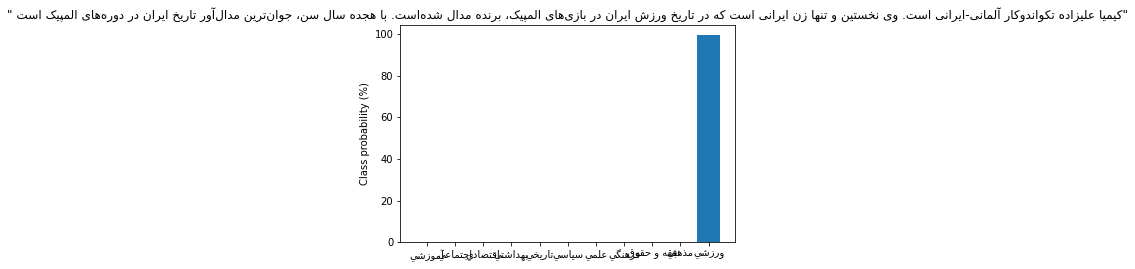

In [45]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد اما مدل آن را به عنوان خبر آموزشی تشخیص داده است.

In [46]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [47]:
preds

[[{'label': 'LABEL_0', 'score': 0.8487057089805603},
  {'label': 'LABEL_1', 'score': 0.06956393271684647},
  {'label': 'LABEL_2', 'score': 0.004388344008475542},
  {'label': 'LABEL_3', 'score': 0.00156887446064502},
  {'label': 'LABEL_4', 'score': 0.004274086561053991},
  {'label': 'LABEL_5', 'score': 0.005922985263168812},
  {'label': 'LABEL_6', 'score': 0.05598587915301323},
  {'label': 'LABEL_7', 'score': 0.005719455890357494},
  {'label': 'LABEL_8', 'score': 0.0017756522865965962},
  {'label': 'LABEL_9', 'score': 0.0009122979245148599},
  {'label': 'LABEL_10', 'score': 0.0011828376445919275}]]

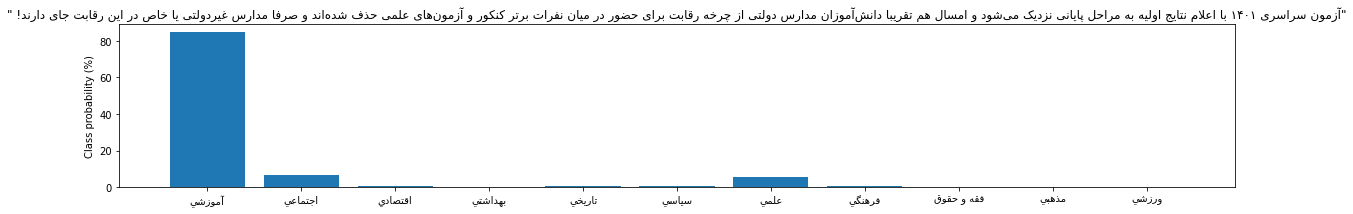

In [48]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()